In [1]:
import pandas as pd
import os
import numpy as np

In [2]:
from sklearn import set_config

set_config(display="text")

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
netflix = pd.read_csv('../data/processed/final_df_all_media.csv')
votes = pd.read_csv('../data/interim/showsWithPrincipalVotes.csv')
netflix = netflix.merge(votes[['combined_title', 'director_votes', 'writer_votes', 'actor_votes']], on='combined_title')

In [5]:
from sklearn.model_selection import train_test_split

movies = netflix[~netflix['is_tv_show']]

drop_cols = ['combined_title', 'release_date', 'lower_title', 'season', 'is_tv_show', 'tconst', 'nudity', 'violence', 'profanity', 'alcohol', 'frightening', 'language',
       'summary', 'director_rank', 'writer_rank', 'actor_rank', 'director_votes', 'writer_votes', 'actor_votes']

X_train, X_test, y_train, y_test = train_test_split(movies.drop(drop_cols + ['is_top10'], axis=1), movies['is_top10'], test_size=0.2, random_state=42, stratify=movies['is_top10'])


In [6]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import FunctionTransformer

class ScaleSwitcher(BaseEstimator):
    
    def __init__(
        self, 
        estimator = FunctionTransformer(),
    ):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 

        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def transform(self, X, y=None):
        return self.estimator.transform(X)

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer, StandardScaler, FunctionTransformer
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

In [186]:
transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),
    ("imputer", KNNImputer(), ['averageRating', 'numVotes', 'runtimeMinutes']),
    ("bagofw", CountVectorizer(min_df=0.01), 'genres')
    ],
    remainder='passthrough')

pipeline = Pipeline(
    steps=[
        ('transformer', transformer),
        ('standardizer', ScaleSwitcher(estimator=Normalizer)),
        ('clf', LogisticRegression(solver='saga', random_state=42))
    ]
)

parameters = [
    {
        'clf__penalty': ['l1', 'l2', 'elasticnet'],
        'clf__C': [0.01, 0.1, 1],
        'clf__l1_ratio':[0, 0.1, 0.5, 0.9, 1],
        'standardizer__estimator':[Normalizer(), StandardScaler(), FunctionTransformer()]
    }
]

gslr1 = GridSearchCV(pipeline, parameters, cv=5, n_jobs = -1, verbose=0, scoring='roc_auc')
gslr1.fit(X_train, y_train)

/home/jyl2fb/.conda/envs/netflix_proj/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/jyl2fb/.conda/envs/netflix_proj/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/jyl2fb/.conda/envs/netflix_proj/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/jyl2fb/.conda/envs/netflix_proj/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/jyl2fb/.conda/envs/netflix_proj/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         KNNImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
               

In [8]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

def get_results_model(model, X_test=X_test, y_test=y_test, name=""):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    print(f"{name} AUC: %0.5f" % roc_auc_score(y_test, y_pred_proba))
    print(f"{name} F1: %0.5f" % f1_score(y_test, y_pred))
    print(f"{name} Accuracy: %0.5f" % accuracy_score(y_test, y_pred))
    return y_pred, y_pred_proba

def get_results_preds(y_labels, y_preds_proba, y_preds,  name=""):

    print(f"{name} AUC: %0.5f" % roc_auc_score(y_labels, y_preds_proba))
    print(f"{name} F1: %0.5f" % f1_score(y_labels, y_preds))
    print(f"{name} Accuracy: %0.5f" % accuracy_score(y_labels, y_preds))

In [9]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

def export_plots(model, X_test, y_test, filename="", name=""):
    # plot roc-auc curve
    rocplot = RocCurveDisplay.from_estimator(model, X_test, y_test)
    rocplot.ax_.set_xlabel('False Positive Rate')
    rocplot.ax_.set_ylabel('True Positive Rate')
    rocplot.ax_.set_title(f'ROC Curve - {name}')
    rocplot.ax_.get_legend().remove()

    # plot precision recall curve
    from sklearn.metrics import PrecisionRecallDisplay

    prplot = PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
    prplot.ax_.set_xlabel('Recall')
    prplot.ax_.set_ylabel('Precision')
    prplot.ax_.set_title(f'Precision Recall Curve - {name}')
    prplot.ax_.get_legend().remove()

    # save roc-auc and precision-recall curve into reports/figures folder

    rocplot.figure_.savefig(f'../reports/figures/{filename}_roc_auc_curve.jpg')
    prplot.figure_.savefig(f'../reports/figures/{filename}_precision_recall_curve.jpg')
    
    return None
    
    
    

0.7894368191376556
Logistic Regression AUC: 0.80232
Logistic Regression F1: 0.76382
Logistic Regression Accuracy: 0.74457


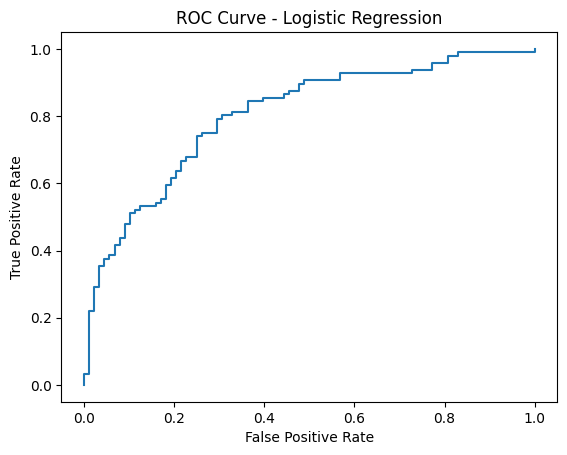

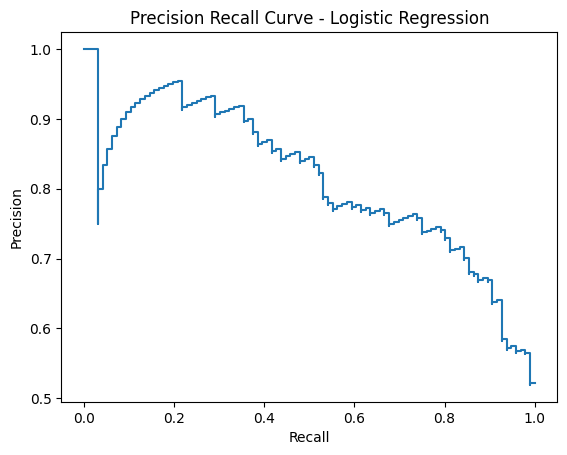

In [192]:
print(gslr.best_score_)
y_pred, y_pred_proba = get_results_model(gslr, X_test, y_test, "Logistic Regression")

export_plots(gslr, X_test, y_test, filename="movie_logistic_reg_ns", name="Logistic Regression")

In [193]:
transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),
    ("imputer", KNNImputer(), ['averageRating', 'numVotes', 'runtimeMinutes']),
    ("bagofw", CountVectorizer(min_df=0.01), 'genres')
    ],
    remainder='passthrough')

pipeline = Pipeline(
    steps=[
        ('transformer', transformer),
        ('standardizer', ScaleSwitcher(estimator=Normalizer)),
        ('clf', DecisionTreeClassifier(random_state=42))
    ]
)

parameters = [
    {
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [3,4,5,6,7],
        'standardizer__estimator':[Normalizer(), StandardScaler(), FunctionTransformer()]
    }
]

gscart1 = GridSearchCV(pipeline, parameters, cv=5, n_jobs = -1, verbose=0, scoring='roc_auc')
gscart1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         KNNImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
               

0.7795094627917882
CART AUC: 0.76497
CART F1: 0.73958
CART Accuracy: 0.72826


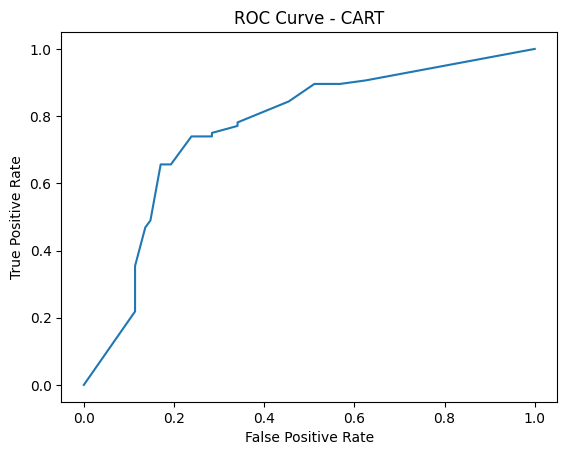

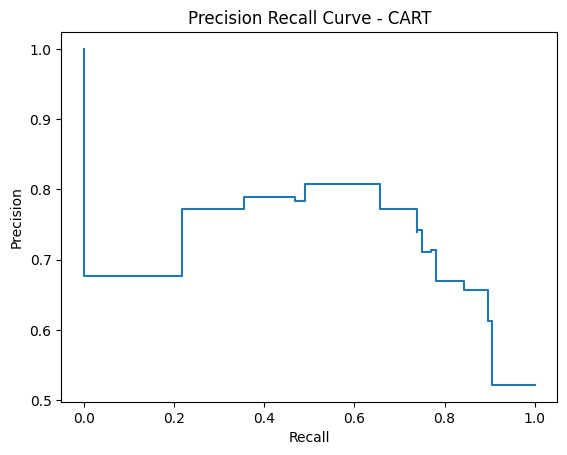

In [194]:
print(gscart.best_score_)
y_pred, y_pred_proba = get_results_model(gscart1, X_test, y_test, "CART")

export_plots(gscart1, X_test, y_test, "movie_cart_ns", "CART")

In [195]:
transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),
    ("imputer", KNNImputer(), ['averageRating', 'numVotes', 'runtimeMinutes']),
    ("bagofw", CountVectorizer(min_df=0.01), 'genres')
    ],
    remainder='passthrough')

pipeline = Pipeline(
    steps=[
        ('transformer', transformer),
        ('standardizer', ScaleSwitcher(estimator=Normalizer)),
        ('clf', RandomForestClassifier(random_state=42))
    ]
)

parameters = [

    {
        'clf__criterion': ['gini', 'entropy'],
        'clf__n_estimators': [10, 100, 200],
        'clf__max_depth': [3,4,5,6,7],
        'standardizer__estimator':[Normalizer(), StandardScaler(), FunctionTransformer()]
    }
]

gsrf1 = GridSearchCV(pipeline, parameters, cv=5, n_jobs = -1, verbose=0, scoring='roc_auc')
gsrf1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         KNNImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
               

0.8133244855324703
RF AUC: 0.82848
RF F1: 0.78641
RF Accuracy: 0.76087


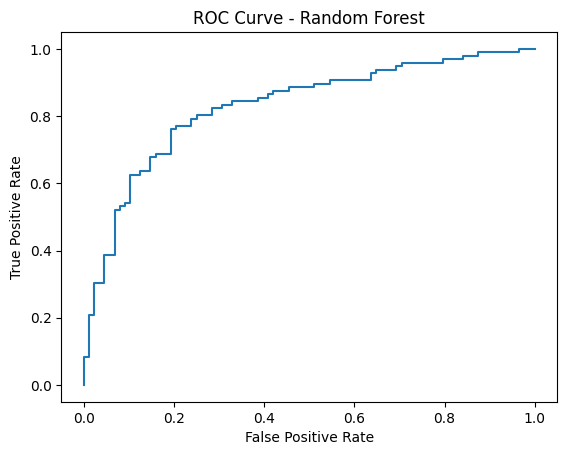

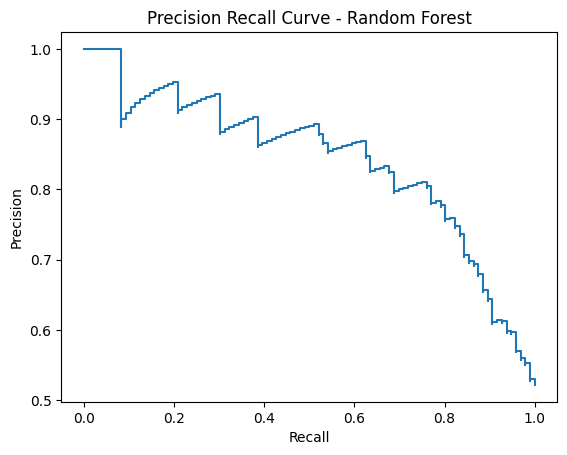

In [198]:
print(gsrf1.best_score_)
y_pred, y_pred_proba = get_results_model(gsrf1, X_test, y_test, "RF")
export_plots(gsrf1, X_test, y_test, "movie_random_forest_ns", "Random Forest")

In [200]:
from xgboost import XGBClassifier

transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),
    ("imputer", KNNImputer(), ['averageRating', 'numVotes', 'runtimeMinutes']),
    ("bagofw", CountVectorizer(min_df=0.01), 'genres'),
    ],
    remainder='passthrough')


pipeline = Pipeline(
    steps=[
        ('transformer', transformer),
        ('standardizer', ScaleSwitcher()),
        ('clf', XGBClassifier(random_state=42))
    ]
)

parameters = [

    {
        'clf__max_depth': [3, 4, 5],
        'clf__learning_rate': [0.01, 0.05, 0.1],
        'clf__n_estimators': [50, 100, 200],
        'clf__subsample': [0.8, 0.85, 0.9],
        'standardizer__estimator':[Normalizer(), StandardScaler(), FunctionTransformer()]
    }
]

gsxgb1 = GridSearchCV(pipeline, parameters, cv=5, n_jobs = -1, verbose=0, scoring='roc_auc')
gsxgb1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         KNNImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
               

0.8296838515714932
XGB AUC: 0.84233
XGB F1: 0.79592
XGB Accuracy: 0.78261


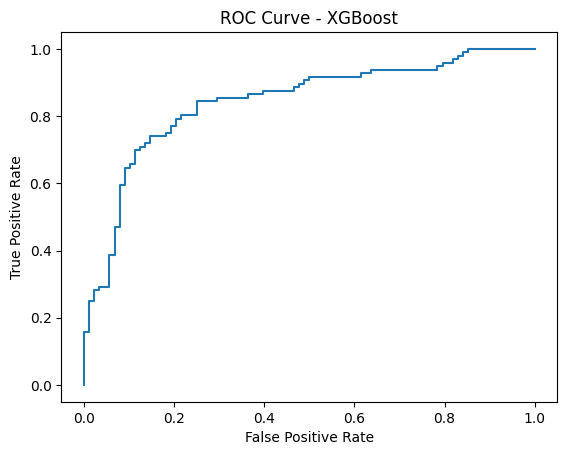

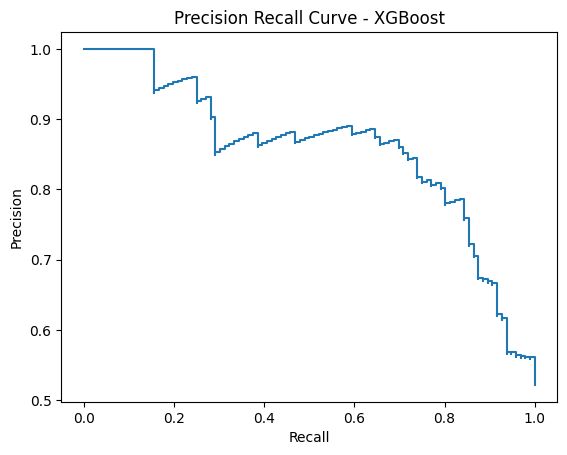

In [202]:
print(gsxgb1.best_score_)
y_pred, y_pred_proba = get_results_model(gsxgb1, X_test, y_test, "XGB")
export_plots(gsxgb1, X_test, y_test, "movie_xgboost_ns", "XGBoost")

## Rankings

In [203]:
drop_cols = ['combined_title', 'release_date', 'lower_title', 'season', 'is_tv_show', 'tconst', 'nudity', 'violence', 'profanity', 'alcohol', 'frightening', 'language',
       'summary', 'director_votes', 'writer_votes', 'actor_votes']

X_train, X_test, y_train, y_test = train_test_split(movies.drop(drop_cols + ['is_top10'], axis=1), movies['is_top10'], test_size=0.2, random_state=42, stratify=movies['is_top10'])


In [204]:
rankings_pipeline = Pipeline([

    ('imputer', KNNImputer()),
    ('logger', FunctionTransformer())
])


transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),
    ("imputer", KNNImputer(), ['averageRating', 'numVotes', 'runtimeMinutes']),
    ("bagofw", CountVectorizer(min_df=0.01), 'genres'),
    ("rankings_pipeline", rankings_pipeline, ['director_rank', 'writer_rank', 'actor_rank'])
    ],
    remainder='passthrough')


pipeline = Pipeline(
    steps=[
        ('transformer', transformer),
        ('standardizer', ScaleSwitcher()),
        ('clf', RandomForestClassifier(random_state=42))
    ]
)

parameters = [

    {
        'clf__criterion': ['gini', 'entropy'],
        'clf__n_estimators': [100, 200,300],
        'clf__max_depth': [6,7,8],
        'standardizer__estimator':[Normalizer(), StandardScaler(), FunctionTransformer()],
        'transformer__rankings_pipeline__logger__func':[np.log1p, np.sqrt, None]
    }
]

gsrf2 = GridSearchCV(pipeline, parameters, cv=5, n_jobs = -1, verbose=0, scoring='roc_auc')
gsrf2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         KNNImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
               

In [169]:
gsrf.best_params_

{'clf__criterion': 'entropy',
 'clf__max_depth': 8,
 'clf__n_estimators': 300,
 'standardizer__estimator': FunctionTransformer(),
 'transformer__rankings_pipeline__logger__func': <ufunc 'log1p'>}

0.8082667226874577
RF AUC: 0.81439
RF F1: 0.76699
RF Accuracy: 0.73913


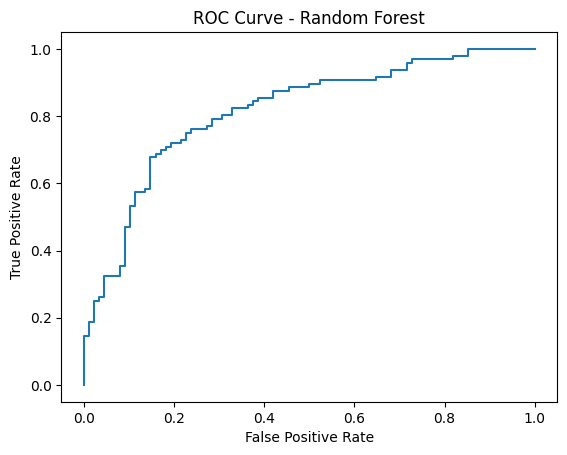

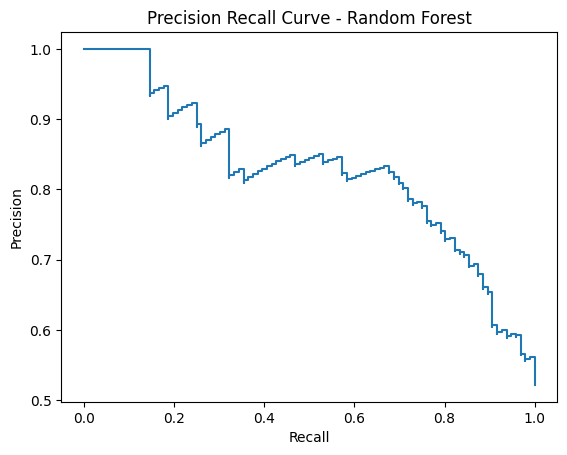

In [205]:
print(gsrf2.best_score_)
y_pred, y_pred_proba = get_results_model(gsrf2, X_test, y_test, "RF")
export_plots(gsrf2, X_test, y_test, "movie_random_forest_ranks_ns", "Random Forest")

In [206]:
from xgboost import XGBClassifier

rankings_pipeline = Pipeline([

    ('imputer', KNNImputer()),
    ('logger', FunctionTransformer())
])


transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),
    ("imputer", KNNImputer(), ['averageRating', 'numVotes', 'runtimeMinutes']),
    ("bagofw", CountVectorizer(min_df=0.01), 'genres'),
    ("rankings_pipeline", rankings_pipeline, ['director_rank', 'writer_rank', 'actor_rank'])
    ],
    remainder='passthrough')


pipeline = Pipeline(
    steps=[
        ('transformer', transformer),
        ('standardizer', ScaleSwitcher()),
        ('clf', XGBClassifier(random_state=42))
    ]
)

parameters = [

    {
        'clf__max_depth': [3, 4, 5],
        'clf__learning_rate': [0.01, 0.05, 0.1],
        'clf__n_estimators': [50, 100, 200],
        'clf__subsample': [0.8, 0.85, 0.9],
        'standardizer__estimator':[Normalizer(), StandardScaler(), FunctionTransformer()],
        'transformer__rankings_pipeline__logger__func':[np.log1p, np.sqrt, None]
    }
]

gsxgb2 = GridSearchCV(pipeline, parameters, cv=5, n_jobs = -1, verbose=0, scoring='roc_auc')
gsxgb2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         KNNImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
               

0.828735296261506
XGB AUC: 0.84422
XGB F1: 0.77778
XGB Accuracy: 0.76087


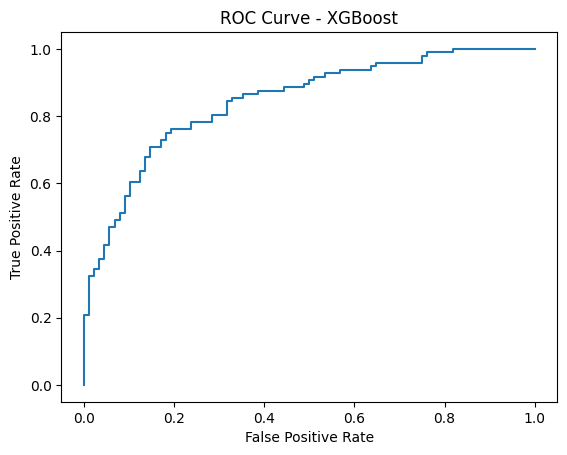

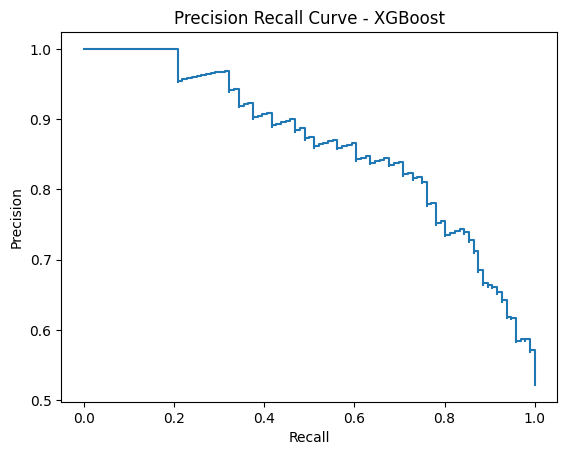

In [207]:
print(gsxgb2.best_score_)
y_pred, y_pred_proba = get_results_model(gsxgb2, X_test, y_test, "XGB")
export_plots(gsxgb2, X_test, y_test, "movie_xgboost_votes_ns", "XGBoost")

## Votes

In [209]:
drop_cols = ['combined_title', 'release_date', 'lower_title', 'season', 'is_tv_show', 'tconst', 'nudity', 'violence', 'profanity', 'alcohol', 'frightening', 'language',
       'summary', 'director_rank', 'writer_rank', 'actor_rank']

X_train, X_test, y_train, y_test = train_test_split(movies.drop(drop_cols + ['is_top10'], axis=1), movies['is_top10'], test_size=0.2, random_state=42, stratify=movies['is_top10'])


In [210]:
rankings_pipeline = Pipeline([

    ('imputer', KNNImputer()),
    ('logger', FunctionTransformer())
])


transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),
    ("imputer", KNNImputer(), ['averageRating', 'numVotes', 'runtimeMinutes']),
    ("bagofw", CountVectorizer(min_df=0.01), 'genres'),
    ("rankings_pipeline", rankings_pipeline, ['director_votes', 'writer_votes', 'actor_votes'])
    ],
    remainder='passthrough')


pipeline = Pipeline(
    steps=[
        ('transformer', transformer),
        ('standardizer', ScaleSwitcher()),
        ('clf', RandomForestClassifier(random_state=42))
    ]
)

parameters = [

    {
        'clf__criterion': ['gini', 'entropy'],
        'clf__n_estimators': [100, 200,300],
        'clf__max_depth': [6,7,8],
        'standardizer__estimator':[Normalizer(), StandardScaler(), FunctionTransformer()],
        'transformer__rankings_pipeline__logger__func':[np.log1p, np.sqrt, None]
    }
]

gsrf3 = GridSearchCV(pipeline, parameters, cv=5, n_jobs = -1, verbose=0, scoring='roc_auc')
gsrf3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         KNNImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
               

In [211]:
gsrf3.best_params_

{'clf__criterion': 'entropy',
 'clf__max_depth': 8,
 'clf__n_estimators': 300,
 'standardizer__estimator': FunctionTransformer(),
 'transformer__rankings_pipeline__logger__func': <ufunc 'sqrt'>}

0.8097310864503495
RF AUC: 0.83061
RF F1: 0.78846
RF Accuracy: 0.76087


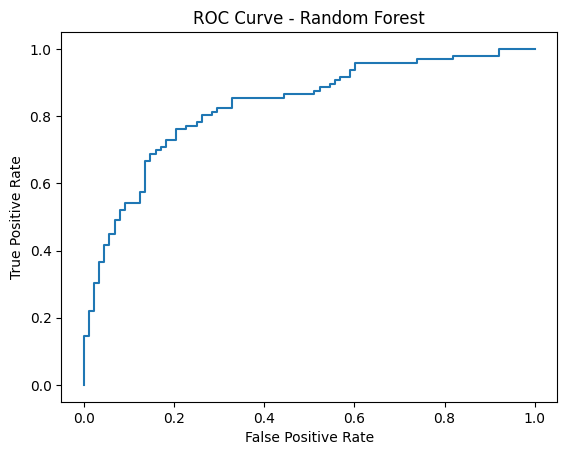

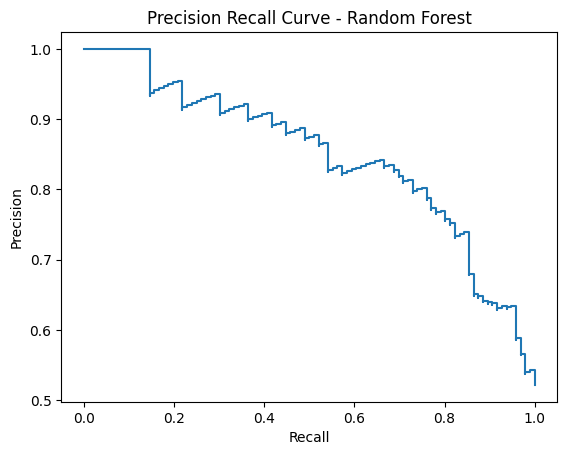

In [212]:
print(gsrf3.best_score_)
y_pred, y_pred_proba = get_results_model(gsrf3, X_test, y_test, "RF")
export_plots(gsrf3, X_test, y_test, "movie_random_forest_votes_ns", "Random Forest")

In [213]:
from xgboost import XGBClassifier

rankings_pipeline = Pipeline([

    ('imputer', KNNImputer()),
    ('logger', FunctionTransformer())
])


transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),
    ("imputer", KNNImputer(), ['averageRating', 'numVotes', 'runtimeMinutes']),
    ("bagofw", CountVectorizer(min_df=0.01), 'genres'),
    ("rankings_pipeline", rankings_pipeline, ['director_votes', 'writer_votes', 'actor_votes'])
    ],
    remainder='passthrough')


pipeline = Pipeline(
    steps=[
        ('transformer', transformer),
        ('standardizer', ScaleSwitcher()),
        ('clf', XGBClassifier(random_state=42))
    ]
)

parameters = [

    {
        'clf__max_depth': [3, 4, 5],
        'clf__learning_rate': [0.01, 0.05, 0.1],
        'clf__n_estimators': [50, 100, 200],
        'clf__subsample': [0.8, 0.85, 0.9],
        'standardizer__estimator':[Normalizer(), StandardScaler(), FunctionTransformer()],
        'transformer__rankings_pipeline__logger__func':[np.log1p, np.sqrt, None]
    }
]

gsxgb3 = GridSearchCV(pipeline, parameters, cv=5, n_jobs = -1, verbose=0, scoring='roc_auc')
gsxgb3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         KNNImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
               

0.8281560862096707
XGB AUC: 0.85736
XGB F1: 0.80402
XGB Accuracy: 0.78804


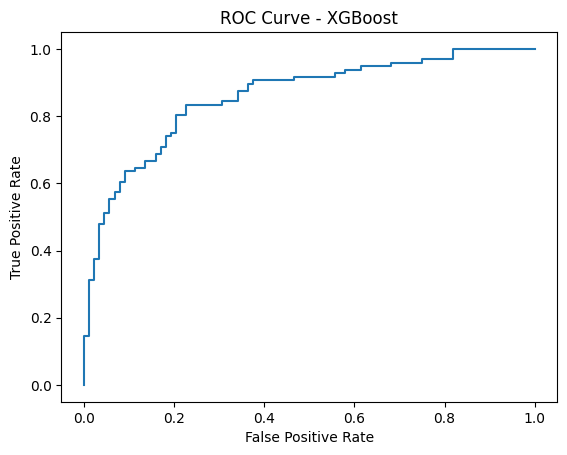

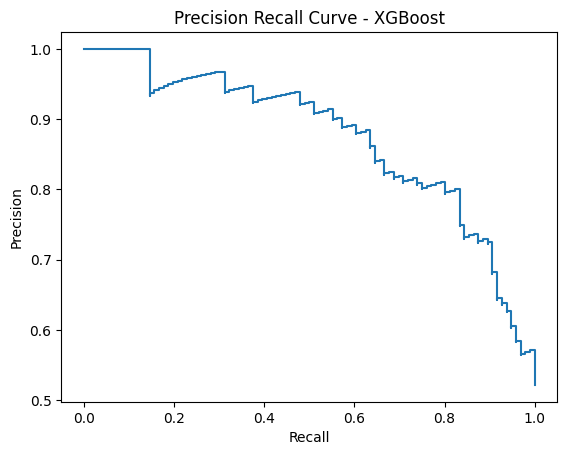

In [214]:
print(gsxgb3.best_score_)
y_pred, y_pred_proba = get_results_model(gsxgb3, X_test, y_test, "XGB")
export_plots(gsxgb3, X_test, y_test, "movie_xgboost_votes_ns", "XGBoost")

## Tags and Language

In [7]:
drop_cols = ['combined_title', 'release_date', 'lower_title', 'season', 'is_tv_show', 'tconst', 'summary', 'director_rank', 'writer_rank', 'actor_rank']

X_train, X_test, y_train, y_test = train_test_split(movies.drop(drop_cols + ['is_top10'], axis=1), movies['is_top10'], test_size=0.2, random_state=42, stratify=movies['is_top10'])


In [21]:
rankings_pipeline = Pipeline([

    ('imputer', KNNImputer()),
    ('logger', FunctionTransformer())
])


transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),
    ("imputer", KNNImputer(), ['averageRating', 'numVotes', 'runtimeMinutes']),
    ("bagofw", CountVectorizer(min_df=0.01), 'genres'),
    ("rankings_pipeline", rankings_pipeline, ['director_votes', 'writer_votes', 'actor_votes']),
    ("onehot_v",OneHotEncoder(handle_unknown='ignore'), ['violence']),                          # one-hot encode violence
    ("onehot_n",OneHotEncoder(handle_unknown='ignore'), ['nudity']),                            # one-hot encode nudity
    ("onehot_p",OneHotEncoder(handle_unknown='ignore'), ['profanity']),                         # one-hot encode profanity
    ("onehot_a",OneHotEncoder(handle_unknown='ignore'), ['alcohol']),                           # one-hot encode alcohol
    ("onehot_f",OneHotEncoder(handle_unknown='ignore'), ['frightening']),                       # one-hot encode frightening
    ("onehot_l",OneHotEncoder(min_frequency=0.01, handle_unknown='infrequent_if_exist'), ['language']),
    ],
    remainder='passthrough')


pipeline = Pipeline(
    steps=[
         ('transformer', transformer),
         ('standardizer', ScaleSwitcher()),
         ('clf', RandomForestClassifier(random_state=42)),
    ]
)

parameters = [

    {
        'clf__criterion': ['gini', 'entropy'],
        'clf__n_estimators': [100, 200,300],
        'clf__max_depth': [6,7,8],
        'standardizer__estimator':[Normalizer(), StandardScaler(), FunctionTransformer()],
        'transformer__rankings_pipeline__logger__func':[np.log1p, np.sqrt, None],
        'transformer__onehot_l__min_frequency': [0, 0.01, 0.02]
    }
]

gsrf4 = GridSearchCV(pipeline, parameters, cv=5, n_jobs = -1, verbose=0, scoring='roc_auc')
gsrf4.fit(X_train, y_train)

/home/jyl2fb/.conda/envs/netflix_proj/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1350 fits failed out of a total of 2430.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
810 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jyl2fb/.conda/envs/netflix_proj/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jyl2fb/.conda/envs/netflix_proj/lib/python3.9/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/jyl2fb/.conda/envs/netflix_proj/lib/python3.9/site-packages/sklearn/pipeline.py", line 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         KNNImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
               

0.8039338766708248
RF AUC: 0.82386
RF F1: 0.76329
RF Accuracy: 0.73370


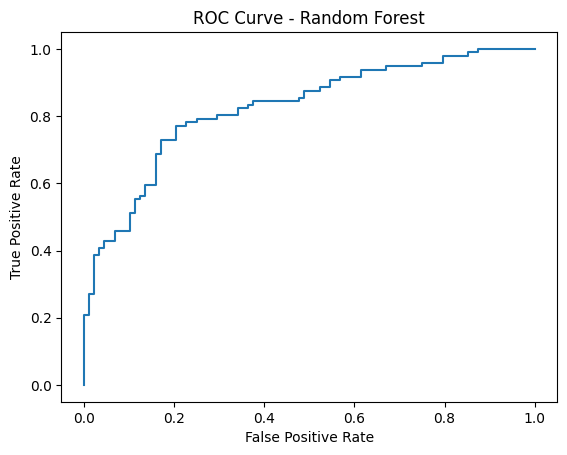

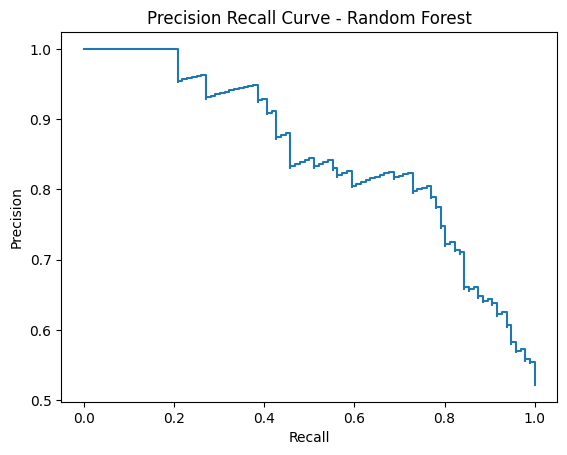

In [22]:
print(gsrf4.best_score_)
y_pred, y_pred_proba = get_results_model(gsrf4, X_test, y_test, "RF")
export_plots(gsrf4, X_test, y_test, "movie_xgboost_votes__ns", "Random Forest")

In [44]:
from xgboost import XGBClassifier

rankings_pipeline = Pipeline([

    ('imputer', KNNImputer()),
    ('logger', FunctionTransformer())
])


transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),
     ("imputer", KNNImputer(), ['averageRating', 'numVotes', 'runtimeMinutes']),
     ("bagofw", CountVectorizer(min_df=0.01), 'genres'),
     ("rankings_pipeline", rankings_pipeline, ['director_votes', 'writer_votes', 'actor_votes']),
     ("onehot_v",OneHotEncoder(handle_unknown='ignore'), ['violence']),                          # one-hot encode violence
     ("onehot_n",OneHotEncoder(handle_unknown='ignore'), ['nudity']),                            # one-hot encode nudity
     ("onehot_p",OneHotEncoder(handle_unknown='ignore'), ['profanity']),                         # one-hot encode profanity
     ("onehot_a",OneHotEncoder(handle_unknown='ignore'), ['alcohol']),                           # one-hot encode alcohol
     ("onehot_f",OneHotEncoder(handle_unknown='ignore'), ['frightening']),                       # one-hot encode frightening
     ("onehot_l",OneHotEncoder( handle_unknown='infrequent_if_exist'), ['language']), 
    ],
    remainder='passthrough')


pipeline = Pipeline(
    steps=[
        ('transformer', transformer),
        ('standardizer', ScaleSwitcher()),
        ('clf', XGBClassifier(random_state=42))
    ]
)

parameters = [

    {
        'clf__max_depth': [2, 3, 4],
        'clf__learning_rate': [0.01, 0.05, 0.1],
        'clf__n_estimators': [100],
        'clf__subsample': [0.5, 0.75, 0.85],
        'clf__colsample_bytree': [0.5, 0.75, 1],
        'clf__alpha': [0, 0.1, 0.2],
        'standardizer__estimator':[Normalizer(), StandardScaler(with_mean=False), FunctionTransformer()],
        'transformer__rankings_pipeline__logger__func':[None],
        'transformer__onehot_l__min_frequency': [0.01, 0.02, 0.03],
    }
]

gsxgb4 = GridSearchCV(pipeline, parameters, cv=5, n_jobs = -1, verbose=0, scoring='roc_auc')
gsxgb4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         KNNImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
               

In [47]:
gsxgb4.best_params_

{'clf__alpha': 0,
 'clf__colsample_bytree': 1,
 'clf__learning_rate': 0.1,
 'clf__max_depth': 3,
 'clf__n_estimators': 100,
 'clf__subsample': 0.85,
 'standardizer__estimator': FunctionTransformer(),
 'transformer__onehot_l__min_frequency': 0.02,
 'transformer__rankings_pipeline__logger__func': None}

0.8274445579835815
XGB AUC: 0.83026
XGB F1: 0.76142
XGB Accuracy: 0.74457


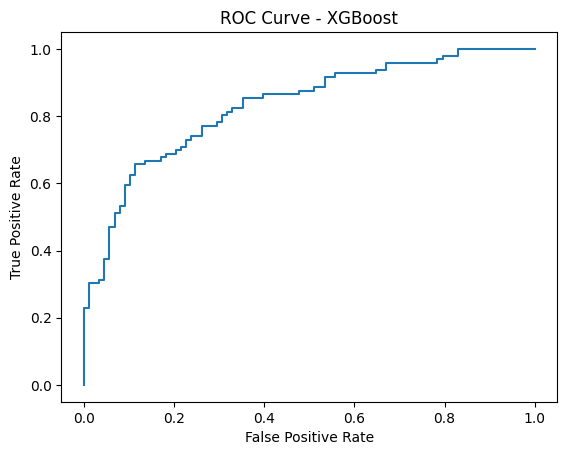

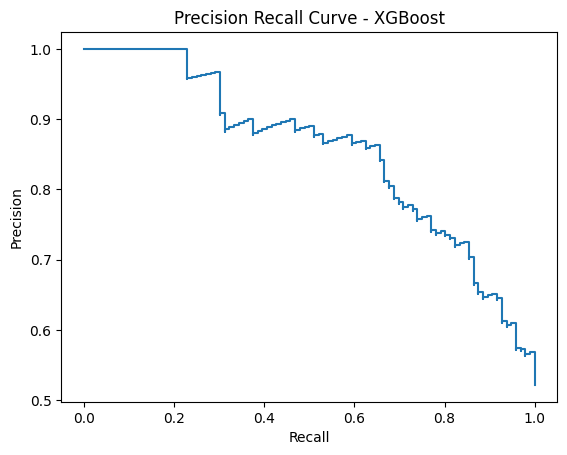

In [18]:
print(gsxgb4.best_score_)
y_pred, y_pred_proba = get_results_model(gsxgb4, X_test, y_test, "XGB")
export_plots(gsxgb4, X_test, y_test, "movie_xgboost_votes_tags_ns", "XGBoost")

## Summary

In [11]:
drop_cols = ['combined_title', 'release_date', 'lower_title', 'season', 'is_tv_show', 'tconst', 'director_rank', 'writer_rank', 'actor_rank']

X_train, X_test, y_train, y_test = train_test_split(movies.drop(drop_cols + ['is_top10'], axis=1), movies['is_top10'], test_size=0.2, random_state=42, stratify=movies['is_top10'])

In [13]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk.stem import SnowballStemmer
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]
        
class StemTokenizer(object):
    def __init__(self):
        self.stemmer = SnowballStemmer('english')
    def __call__(self, articles):
        return [self.stemmer.stem(t) for t in word_tokenize(articles)]


In [14]:
from sklearn.feature_extraction import text

custom_stop_words = []
# add lemmatized stop words to stop_words list

for i in text.ENGLISH_STOP_WORDS:
    custom_stop_words.append(WordNetLemmatizer().lemmatize(i))
lemma_stop_words = text.ENGLISH_STOP_WORDS.union(custom_stop_words)

In [19]:
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

rankings_pipeline = Pipeline([

    ('imputer', KNNImputer()),
    ('logger', FunctionTransformer())
])


transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),
     ("imputer", KNNImputer(), ['averageRating', 'numVotes', 'runtimeMinutes']),
     ("bagofw", CountVectorizer(min_df=0.01), 'genres'),
     ("rankings_pipeline", rankings_pipeline, ['director_votes', 'writer_votes', 'actor_votes']),
     ("bagofwords", CountVectorizer(stop_words='english', lowercase=True), 'summary'),
     ("onehot_v",OneHotEncoder(handle_unknown='ignore'), ['violence']),                          # one-hot encode violence
     ("onehot_n",OneHotEncoder(handle_unknown='ignore'), ['nudity']),                            # one-hot encode nudity
     ("onehot_p",OneHotEncoder(handle_unknown='ignore'), ['profanity']),                         # one-hot encode profanity
     ("onehot_a",OneHotEncoder(handle_unknown='ignore'), ['alcohol']),                           # one-hot encode alcohol
     ("onehot_f",OneHotEncoder(handle_unknown='ignore'), ['frightening']),                       # one-hot encode frightening
     ("onehot_l",OneHotEncoder( handle_unknown='infrequent_if_exist'), ['language']), 
    ],
    remainder='passthrough')


pipeline = Pipeline(
    steps=[
        ('transformer', transformer),
        ('standardizer', ScaleSwitcher()),
        ('clf', XGBClassifier(random_state=42))
    ]
)

parameters = [

    {
        'clf__max_depth': [3],
        'clf__learning_rate': [0.1],
        'clf__n_estimators': [100],
        'clf__subsample': [0.85],
        'clf__colsample_bytree': [1],
        'clf__alpha': [0],
        'standardizer__estimator':[FunctionTransformer()],
        'transformer__rankings_pipeline__logger__func':[None],
        'transformer__onehot_l__min_frequency': [0.02],
        'transformer__bagofwords__tokenizer':[LemmaTokenizer(), StemTokenizer()],
        'transformer__bagofwords__min_df':[0, 0.2, 0.4],
        
        
    }
]

gsxgb5 = GridSearchCV(pipeline, parameters, cv=5, n_jobs = -1, verbose=0, scoring='roc_auc')
gsxgb5.fit(X_train, y_train)

/home/jyl2fb/.conda/envs/netflix_proj/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/home/jyl2fb/.conda/envs/netflix_proj/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/home/jyl2fb/.conda/envs/netflix_proj/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/home/jyl2fb/.conda/envs/netflix_proj/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsist

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         KNNImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
               

In [20]:
gsxgb5.best_params_

{'clf__alpha': 0,
 'clf__colsample_bytree': 1,
 'clf__learning_rate': 0.1,
 'clf__max_depth': 3,
 'clf__n_estimators': 100,
 'clf__subsample': 0.85,
 'standardizer__estimator': FunctionTransformer(),
 'transformer__bagofwords__min_df': 0.4,
 'transformer__bagofwords__tokenizer': <__main__.LemmaTokenizer at 0x2aab1e5ddf40>,
 'transformer__onehot_l__min_frequency': 0.02,
 'transformer__rankings_pipeline__logger__func': None}

0.8297618314122603
XGB AUC: 0.84103
XGB F1: 0.77612
XGB Accuracy: 0.75543


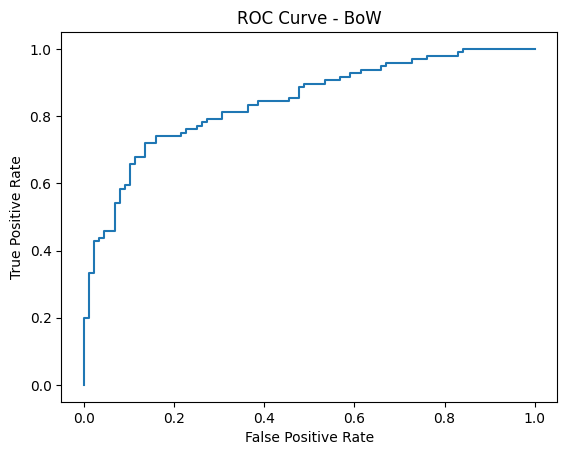

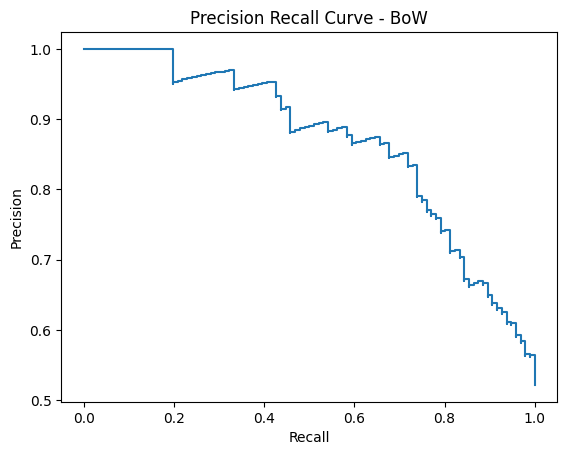

In [23]:
print(gsxgb5.best_score_)
y_pred, y_pred_proba = get_results_model(gsxgb5, X_test, y_test, "XGB")
export_plots(gsxgb5, X_test, y_test, "movie_xgboost_votes_tags_bow", "BoW")

In [114]:
def get_feature_names(estimator, remove_features=['release_year', 'titleType', 'numVotes', 'genres', 'summary', 'nudity', 'violence', 'profanity', 'alcohol', 'frightening', 'language', 'director_votes', 'writer_votes', 'actor_votes']):
    """Get feature names from a pipeline or column transformer."""
    feature_names = []
    for transformer in estimator.transformers_:
        try:
            if transformer[0] == 'rankings_pipeline':
                feature_names.append(['director_votes', 'writer_votes', 'actor_votes'])
            elif type(transformer[1]) == CountVectorizer:
                feature_names.append(transformer[2] + "_" + transformer[1].get_feature_names_out())
            else:
                feature_names.append(transformer[1].get_feature_names_out())
        except:
            pass
    feature_names = np.concatenate(feature_names)
    unchanged_features = [feature for feature in estimator.feature_names_in_ if feature not in remove_features]
    feature_names = np.concatenate([feature_names, unchanged_features])
    return feature_names

In [76]:
feature_names = get_feature_names(gsxgb5.best_estimator_['transformer'])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


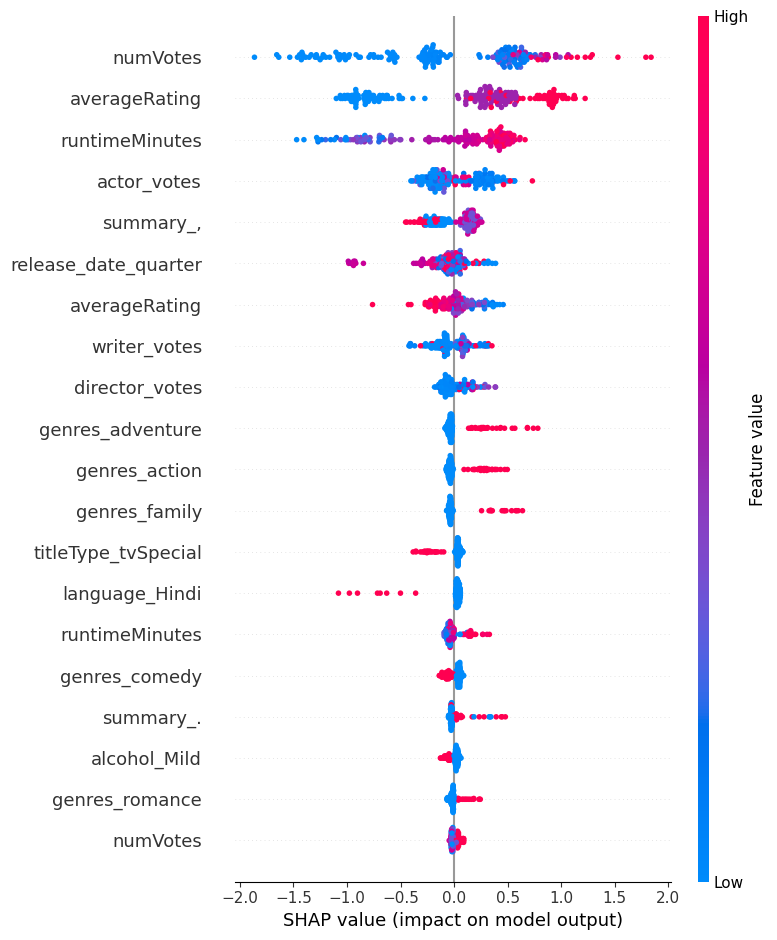

In [91]:
import shap
from xgboost import DMatrix

# make shap values
transformed_test = gsxgb5.best_estimator_['transformer'].transform(X_test)
explainer = shap.TreeExplainer(gsxgb5.best_estimator_['clf'])
shap_values = explainer.shap_values(DMatrix(transformed_test, y_test))

# plot shap values
shap.summary_plot(shap_values, pd.DataFrame(transformed_test.todense()), feature_names=feature_names, show=False)
f.savefig('../reports/figures/movie_xgb_full_summary_plot.jpg')

## TF-IDF

In [26]:
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


rankings_pipeline = Pipeline([

    ('imputer', KNNImputer()),
    ('logger', FunctionTransformer())
])


transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),
     ("imputer", KNNImputer(), ['averageRating', 'numVotes', 'runtimeMinutes']),
     ("bagofw", CountVectorizer(min_df=0.01), 'genres'),
     ("rankings_pipeline", rankings_pipeline, ['director_votes', 'writer_votes', 'actor_votes']),
     ("tfidf", TfidfVectorizer(stop_words='english', lowercase=True), 'summary'),
     ("onehot_v",OneHotEncoder(handle_unknown='ignore'), ['violence']),                          # one-hot encode violence
     ("onehot_n",OneHotEncoder(handle_unknown='ignore'), ['nudity']),                            # one-hot encode nudity
     ("onehot_p",OneHotEncoder(handle_unknown='ignore'), ['profanity']),                         # one-hot encode profanity
     ("onehot_a",OneHotEncoder(handle_unknown='ignore'), ['alcohol']),                           # one-hot encode alcohol
     ("onehot_f",OneHotEncoder(handle_unknown='ignore'), ['frightening']),                       # one-hot encode frightening
     ("onehot_l",OneHotEncoder( handle_unknown='infrequent_if_exist'), ['language']), 
    ],
    remainder='passthrough')


pipeline = Pipeline(
    steps=[
        ('transformer', transformer),
        ('standardizer', ScaleSwitcher()),
        ('clf', XGBClassifier(random_state=42))
    ]
)

parameters = [

    {
        'clf__max_depth': [3],
        'clf__learning_rate': [0.1],
        'clf__n_estimators': [100],
        'clf__subsample': [0.85],
        'clf__colsample_bytree': [1],
        'clf__alpha': [0],
        'standardizer__estimator':[FunctionTransformer()],
        'transformer__rankings_pipeline__logger__func':[None],
        'transformer__onehot_l__min_frequency': [0.02],
        'transformer__tfidf__tokenizer':[LemmaTokenizer(), StemTokenizer()],
        'transformer__tfidf__min_df':[0, 0.2, 0.4],
        
        
    }
]

gsxgb6 = GridSearchCV(pipeline, parameters, cv=5, n_jobs = -1, verbose=0, scoring='roc_auc')
gsxgb6.fit(X_train, y_train)

/home/jyl2fb/.conda/envs/netflix_proj/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/home/jyl2fb/.conda/envs/netflix_proj/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/home/jyl2fb/.conda/envs/netflix_proj/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/home/jyl2fb/.conda/envs/netflix_proj/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsist

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         KNNImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
               

0.8210207313601362
XGB AUC: 0.84505
XGB F1: 0.76923
XGB Accuracy: 0.75543


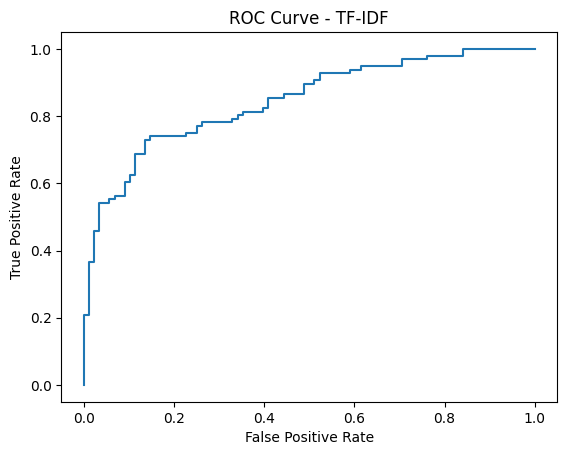

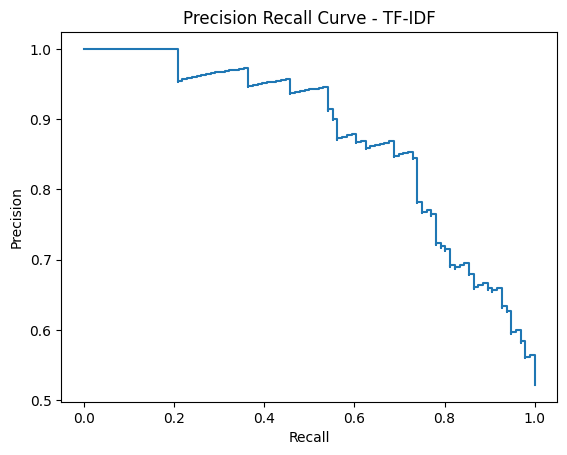

In [27]:
print(gsxgb6.best_score_)
y_pred, y_pred_proba = get_results_model(gsxgb6, X_test, y_test, "XGB")
export_plots(gsxgb6, X_test, y_test, "movie_xgboost_votes_tags_bow", "TF-IDF")

In [43]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
tokenizer = AutoTokenizer.from_pretrained("joeddav/distilbert-base-uncased-go-emotions-student")
model = AutoModelForSequenceClassification.from_pretrained("joeddav/distilbert-base-uncased-go-emotions-student")
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, top_k=1, )

In [ ]:
X_train['emotion'] = X_train['summary'].apply(lambda x: classifier(x)[0][0]['label'])
X_test['emotion'] = X_test['summary'].apply(lambda x: classifier(x)[0][0]['label'])

In [55]:
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


rankings_pipeline = Pipeline([

    ('imputer', KNNImputer()),
    ('logger', FunctionTransformer())
])


transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),
     ("imputer", KNNImputer(), ['averageRating', 'numVotes', 'runtimeMinutes']),
     ("bagofw", CountVectorizer(min_df=0.01), 'genres'),
     ("rankings_pipeline", rankings_pipeline, ['director_votes', 'writer_votes', 'actor_votes']),
     ("bagofwords", CountVectorizer(stop_words='english', lowercase=True), 'summary'),
     ("emotion", OneHotEncoder(handle_unknown='ignore'), ['emotion']),
     ("onehot_v",OneHotEncoder(handle_unknown='ignore'), ['violence']),                          # one-hot encode violence
     ("onehot_n",OneHotEncoder(handle_unknown='ignore'), ['nudity']),                            # one-hot encode nudity
     ("onehot_p",OneHotEncoder(handle_unknown='ignore'), ['profanity']),                         # one-hot encode profanity
     ("onehot_a",OneHotEncoder(handle_unknown='ignore'), ['alcohol']),                           # one-hot encode alcohol
     ("onehot_f",OneHotEncoder(handle_unknown='ignore'), ['frightening']),                       # one-hot encode frightening
     ("onehot_l",OneHotEncoder( handle_unknown='infrequent_if_exist'), ['language']), 
    ],
    remainder='passthrough')


pipeline = Pipeline(
    steps=[
        ('transformer', transformer),
        ('standardizer', ScaleSwitcher()),
        ('clf', XGBClassifier(random_state=42))
    ]
)

parameters = [

    {
        'clf__max_depth': [3],
        'clf__learning_rate': [0.1],
        'clf__n_estimators': [100],
        'clf__subsample': [0.85],
        'clf__colsample_bytree': [1],
        'clf__alpha': [0],
        'standardizer__estimator':[FunctionTransformer()],
        'transformer__rankings_pipeline__logger__func':[None],
        'transformer__onehot_l__min_frequency': [0.02],
        'transformer__bagofwords__tokenizer':[LemmaTokenizer(), StemTokenizer()],
        'transformer__bagofwords__min_df':[0, 0.2, 0.4],
        
        
    }
]

gsxgb7 = GridSearchCV(pipeline, parameters, cv=5, n_jobs = -1, verbose=0, scoring='roc_auc')
gsxgb7.fit(X_train, y_train)

/home/jyl2fb/.conda/envs/netflix_proj/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/home/jyl2fb/.conda/envs/netflix_proj/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/home/jyl2fb/.conda/envs/netflix_proj/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/home/jyl2fb/.conda/envs/netflix_proj/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsist

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         KNNImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
               

0.8217933988070596
XGB AUC: 0.84055
XGB F1: 0.74396
XGB Accuracy: 0.71196


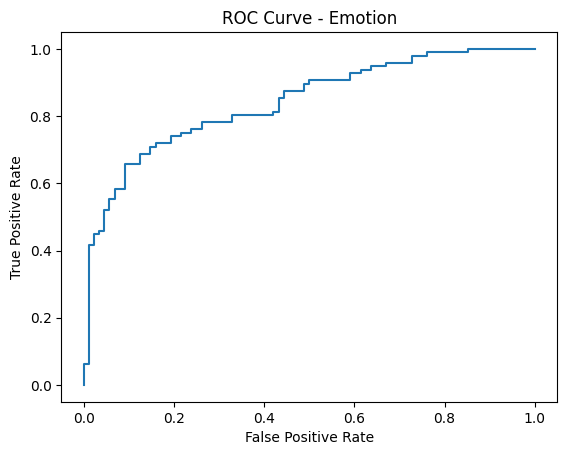

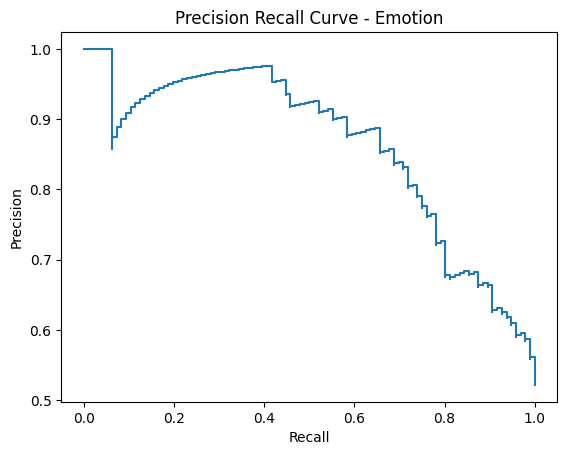

In [56]:
print(gsxgb7.best_score_)
y_pred, y_pred_proba = get_results_model(gsxgb7, X_test, y_test, "XGB")
export_plots(gsxgb7, X_test, y_test, "movie_xgboost_votes_tags_bow_emotion", "Emotion")

## Final Model

In [15]:
drop_cols = ['combined_title', 'release_date', 'lower_title', 'season', 'is_tv_show', 'tconst','numVotes', 'averageRating', 'director_votes', 'writer_votes', 'actor_votes']

X_train, X_test, y_train, y_test = train_test_split(movies.drop(drop_cols + ['is_top10'], axis=1), movies['is_top10'], test_size=0.2, random_state=42, stratify=movies['is_top10'])

In [16]:
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

rankings_pipeline = Pipeline([

    ('imputer', KNNImputer()),
    ('logger', FunctionTransformer())
])


transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),
     ("imputer", KNNImputer(), ['runtimeMinutes']),
     ("genres", CountVectorizer(min_df=0.01,token_pattern="(?u)\\b[\\w-]+\\b"), 'genres'),
     ("rankings_pipeline", rankings_pipeline, ['director_rank', 'writer_rank', 'actor_rank']),
     ("bagofwords", CountVectorizer(tokenizer=LemmaTokenizer(), stop_words=lemma_stop_words, lowercase=True), 'summary'),
     ("onehot_v",OneHotEncoder(handle_unknown='ignore'), ['violence']),                          # one-hot encode violence
     ("onehot_n",OneHotEncoder(handle_unknown='ignore'), ['nudity']),                            # one-hot encode nudity
     ("onehot_p",OneHotEncoder(handle_unknown='ignore'), ['profanity']),                         # one-hot encode profanity
     ("onehot_a",OneHotEncoder(handle_unknown='ignore'), ['alcohol']),                           # one-hot encode alcohol
     ("onehot_f",OneHotEncoder(handle_unknown='ignore'), ['frightening']),                       # one-hot encode frightening
     ("onehot_l",OneHotEncoder( handle_unknown='infrequent_if_exist'), ['language']), 
    ],
    remainder='passthrough')


pipeline = Pipeline(
    steps=[
        ('transformer', transformer),
        ('standardizer', ScaleSwitcher()),
        ('clf', XGBClassifier(random_state=42))
    ]
)

parameters = [

    {
        'clf__max_depth': [3],
        'clf__learning_rate': [0.01, 0.05, 0.1],
        'clf__n_estimators': [100],
        'clf__subsample': [0.85],
        'clf__colsample_bytree': [0.9, 1],
        'clf__alpha': [0],
        'standardizer__estimator':[Normalizer(), StandardScaler(with_mean=False), FunctionTransformer()],
        'transformer__rankings_pipeline__logger__func':[np.log1p, np.sqrt, None],
        'transformer__onehot_l__min_frequency': [0.02],
        'transformer__bagofwords__min_df':[0.1, 0.2, 0.3],
    }
]

gsxgb8 = GridSearchCV(pipeline, parameters, cv=5, n_jobs = -1, verbose=0, scoring='roc_auc')
gsxgb8.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         KNNImputer(),
                                                                         ['runtimeMinutes']),
                                                                        ('genres',
                                                                         CountVectorizer(min_df=0.01,
       

In [17]:
gsxgb8.best_params_

{'clf__alpha': 0,
 'clf__colsample_bytree': 0.9,
 'clf__learning_rate': 0.05,
 'clf__max_depth': 3,
 'clf__n_estimators': 100,
 'clf__subsample': 0.85,
 'standardizer__estimator': FunctionTransformer(),
 'transformer__bagofwords__min_df': 0.3,
 'transformer__onehot_l__min_frequency': 0.02,
 'transformer__rankings_pipeline__logger__func': None}

0.8157237890775961
XGB AUC: 0.83286
XGB F1: 0.77612
XGB Accuracy: 0.75543


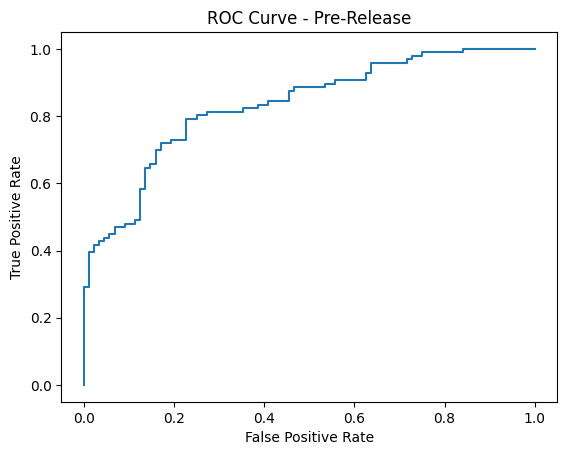

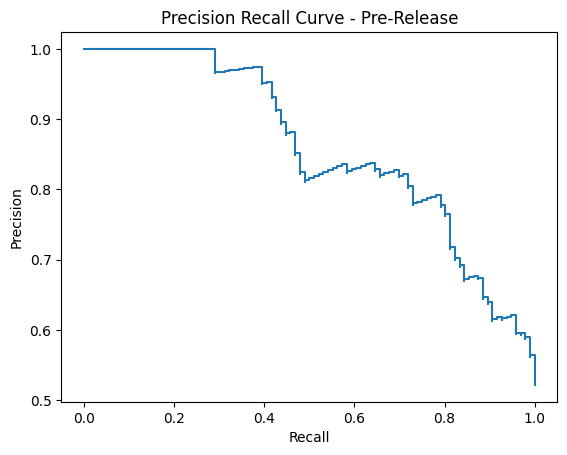

In [18]:
print(gsxgb8.best_score_)
y_pred, y_pred_proba = get_results_model(gsxgb8, X_test, y_test, "XGB")
export_plots(gsxgb8, X_test, y_test, "movie_xgboost_pre-release", "Pre-Release")

In [34]:
def get_feature_names(estimator, remove_features=['titleType', 'numVotes', 'runtimeMinutes', 'genres', 'summary', 'nudity', 'violence', 'profanity', 'alcohol', 'frightening', 'language', 'director_rank', 'writer_rank', 'actor_rank']):
    """Get feature names from a pipeline or column transformer."""
    feature_names = []
    for transformer in estimator.transformers_:
        try:
            if transformer[0] == 'rankings_pipeline':
                feature_names.append(['director_rank', 'writer_rank', 'actor_rank'])
            elif type(transformer[1]) == CountVectorizer:
                feature_names.append(transformer[2] + "_" + transformer[1].get_feature_names_out())
            else:
                feature_names.append(transformer[1].get_feature_names_out())
        except:
            pass
    feature_names = np.concatenate(feature_names)
    unchanged_features = [feature for feature in estimator.feature_names_in_ if feature not in remove_features]
    feature_names = np.concatenate([feature_names, unchanged_features])
    return feature_names

In [35]:
feature_names = get_feature_names(gsxgb8.best_estimator_['transformer'])

In [36]:
feature_names

array(['titleType_short', 'titleType_tvSpecial', 'runtimeMinutes',
       'genres_action', 'genres_adventure', 'genres_animation',
       'genres_biography', 'genres_comedy', 'genres_crime',
       'genres_documentary', 'genres_drama', 'genres_family',
       'genres_fantasy', 'genres_history', 'genres_horror',
       'genres_music', 'genres_musical', 'genres_mystery',
       'genres_romance', 'genres_sci-fi', 'genres_short', 'genres_sport',
       'genres_thriller', 'director_rank', 'writer_rank', 'actor_rank',
       'summary_,', 'summary_.', 'violence_Mild', 'violence_Moderate',
       'violence_None', 'violence_Severe', 'violence_nan', 'nudity_Mild',
       'nudity_Moderate', 'nudity_None', 'nudity_Severe', 'nudity_nan',
       'profanity_Mild', 'profanity_Moderate', 'profanity_None',
       'profanity_Severe', 'profanity_nan', 'alcohol_Mild',
       'alcohol_Moderate', 'alcohol_None', 'alcohol_Severe',
       'alcohol_nan', 'frightening_Mild', 'frightening_Moderate',
       'frigh

In [37]:
import shap
from xgboost import DMatrix

# make shap values
transformed_test = gsxgb8.best_estimator_['transformer'].transform(X_test)
transformed_train = gsxgb8.best_estimator_['transformer'].transform(X_train)
explainer = shap.TreeExplainer(gsxgb8.best_estimator_['clf'])
shap_values = explainer.shap_values(DMatrix(transformed_test, y_test))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


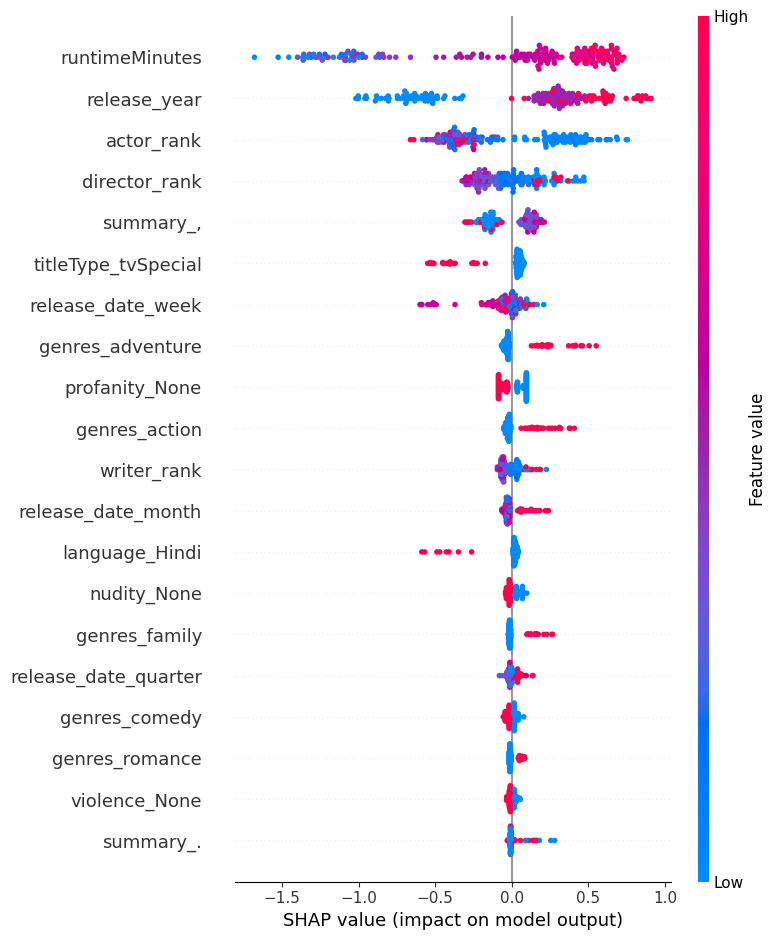

In [38]:
# plot shap values
shap.summary_plot(shap_values, pd.DataFrame(transformed_test.todense()), feature_names=feature_names, show=False)
plt.savefig('../reports/figures/movie_xgb_pre_release_summary_plot.jpg')

In [109]:
shap.initjs()

In [134]:
def find_title_iloc(search_str='Don\'t Look Up', transformer=gsxgb8.best_estimator_['transformer'], X_train=X_train, X_test=X_test, ):
    orig_index = movies[movies['combined_title'].str.contains(search_str)].index[0]
    if orig_index in X_train.index:
        transformed_train = transformer.transform(X_train)
        shap_values_train = explainer.shap_values(DMatrix(transformed_train, y_train))
        X_train_index_reset = X_train.reset_index()
        new_index = X_train_index_reset[X_train_index_reset['index']==orig_index].index[0]
        return shap.force_plot(explainer.expected_value, shap_values_train[new_index], pd.DataFrame(transformed_train.todense()).iloc[new_index,:], feature_names=feature_names, link='logit', show=False)

 
    
    elif orig_index in X_test.index:
        transformed_test = transformer.transform(X_test)
        shap_values_test = explainer.shap_values(DMatrix(transformed_test, y_test))
        X_test_index_reset = X_test.reset_index()
        new_index = X_test_index_reset[X_test_index_reset['index']==orig_index].index[0]
        return shap.force_plot(explainer.expected_value, shap_values_test[new_index], pd.DataFrame(transformed_test.todense()).iloc[new_index,:], feature_names=feature_names, link='logit')
    else:
        print("Not Found")
        return None
    

In [136]:
find_title_iloc('Don\'t Look Up')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [117]:
find_title_iloc('Red Notice')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [118]:
find_title_iloc('Extraction')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
